# Bayes, Bootstrap, MLE & All That
-----
The title for this post is inspired by [Div, Grad, Curl & All That](https://www.google.com/books/edition/_/sembQgAACAAJ?hl=en) which I used as a undergraduate to help learn vector calculus.


why Poisson(2).prob(2) == Poisson(2).prob(3)?

__[1. Introduction](#first-bullet)__

__[2. Sampling A Poisson Distribution Written In Scala with Py4J](#second-bullet)__

__[3. The Maximum Likelyhood Estimator](#third-bullet)__

__[4. Confidence Intervals From The Fisher Information](#fourth-bullet)__

## Introduction <a class="anchor" id="first-bullet"></a>
-------------

In this post I want to go back to the basics of statistics, but from an advanced view point. By "advanced view point" I mean, both from a mathematical and technical point of view. My object is to go back to the basics of 

    Estimating a single parameter value from a distribution and then quantifying the uncertantity in the estimate using a few methods.
    
In general I will take three approaches to this two of which are [frequentist](https://en.wikipedia.org/wiki/Frequentist_inference) and one that is [Bayesian](https://en.wikipedia.org/wiki/Bayesian_statistics).  I'll admit now, I am not as familar with Bayesian methods and that's why I'll be sticking to a simple example of estimating the mean rate or $\lambda$ in a [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution#) from sampled data. I don't believe one approach to statistics is inherently better than the other, but have found so-called frequentist for me to be easier to understand, easier to implement and additionally I found Fisherian approaches satisfying from a mathematical point of view.

From the technical side, I wanted to do something different decided to write the distribution for generating data in [Scala](https://www.scala-lang.org/) and use that distribution from Python. But why did I write my distribution in Scala? Well, I like Scala and enjoyed the challenge of writing a Poisson distribution using a functional approach. I also wanted to learn more about how to use [Py4J](https://www.py4j.org/) which can be used to work with functions and objects in the [JVM](https://en.wikipedia.org/wiki/Java_virtual_machine) from Python. [Apache Spark](https://spark.apache.org/) actually uses Py4J in PySpark to write Python wrappers for Scala code. I've used both PySpark and Spark in Scala and this gave me an opportunity to understand how PySpark works better.

Let's get into how I wrote the Poisson distribution in Scala and used it to sample data from in Python.

## 2. Sampling A Poisson Distribution Written In Scala with Py4J <a class="anchor" id="second-bullet"></a>
---------------

The first thing I need is data from a Poisson distribution to estimate the mean rate $\lambda$ and for that purpose I wrote a [Poisson distribution in Scala](https://github.com/mdh266/PoissonDistributionInScala). The Poisson distribution is a probability distribution for a random variable $y$ that represents some count phenomena, i.e. a number of non-zero integer occurences in some fixed time frame.  For example the number of trains passing through a station per day or the number of customers that visit a website per hour are governed by Poisson distribution. The disibution is,

$$ p(y \, = \, k)  \; = \; \frac{\lambda^{k} e^{-\lambda} }{k!} $$

The parameter $\lambda$ is the rate variable, i.e. the true number of customers that visit the website per hour.

The first step was to create the Poisson class. I did this in a previous [project](https://github.com/mdh266/PoissonDistributionInScala), however, one key difference is the return value of any public value needs to be Java object. Specifically the [sample](https://github.com/mdh266/BayesBootstrapMLE/blob/main/src/main/scala/Poisson.scala) method needs to return a Java List ([java.util.List[Int]](https://www.javatpoint.com/java-list)) of integers. I originally tried returning a [Scala List](https://www.scala-lang.org/api/current/scala/collection/immutable/List.html) which worked fine in pure Scala, but when Py4J was not able to serialize this object so well and Python type of returned list was "Java Object".

In order to use this class from Python we need to do three things from the Scala point of view:

1. Create a [Gateway Server](https://www.py4j.org/_static/javadoc/index.html?py4j/GatewayServer.html)
2. Create a class entrypoint to allow for setting object attributes outside of the constructor
3. Package the code as a jar using a build tool such as [Maven](https://maven.apache.org/) or [SBT](https://www.scala-sbt.org/)


The first step is pretty straight forward to from the [Py4J Documentation](https://www.py4j.org/getting_started.html) and is in the [Main.Scala](https://github.com/mdh266/BayesBootstrapMLE/blob/main/src/main/scala/Main.scala) object:

    import py4j.GatewayServer

    object Main {
        def main(args: Array[String]) = {
            val server = new GatewayServer(new PoissonEntryPoint())
            server.start()
            System.out.println("Gateway Server Started")
        }
    }
    
The GatewayServer in the author's own words *it allows Python programs to communicate with the JVM through a local network socket.*  The GatewayServer takes an *entrypoint* as a parameter which can be any object, see [here](https://www.py4j.org/getting_started.html#writing-the-python-program).  However, the entrypoint doesn't really offer a way for us to pass the $\lambda$ value from [Python](https://www.py4j.org/getting_started.html#writing-the-python-program) to the Poisson constructor in Scala. To get around this issue I created a [PoissonEntryPoint](https://github.com/mdh266/BayesBootstrapMLE/blob/main/src/main/scala/PoissonEntryPoint.scala) case class:

    case class PoissonEntryPoint() {

        def Poisson(lambda : Double) : PoissonDistribution = {
            new PoissonDistribution()
        }
    }

This case class really just acts a [Singleton](https://docs.scala-lang.org/tour/singleton-objects.html), but is a class instead of an object. The point of the `PoissonEntryPoint` class is simply to be able to create a Poisson class with a specific $\lambda$ value after starting the GatewayServer.  

Now let's talk about how the project structure and packaging it for use.  The project structure is:

    src/
       main/
           scala/
               Main.scala
               PoissonDistribution.scala
               PoissonEntryPoint.scala
    pom.xml
    

The [pom.xml](https://maven.apache.org/guides/introduction/introduction-to-the-pom.html#:~:text=Available%20Variables-,What%20is%20a%20POM%3F,default%20values%20for%20most%20projects.) file is the project object model and is a file which all contains all the instructions for [Maven](https://maven.apache.org/). I won't go into the details here, but I will say that Maven is a java tool to compile and package our code while [SBT](https://www.scala-sbt.org/) is the Scala equivalent. Since Scala is a [JVM language](https://en.wikipedia.org/wiki/List_of_JVM_languages) we can use either, however, I went with Maven since I'm more familiar with it and because examples with Py4J were much more easy to find.

We package our code into a [uber jar](https://stackoverflow.com/questions/11947037/what-is-an-uber-jar) with the command:

    mvn package 
    
Then we can start our our Py4J Web server with the command:


    java -jar target/poisson-1.0-jar-with-dependencies.jar

Now we can start up our Jupyter notebook and connect Python to the JVM with the following code taken directly from [Py4J's](https://www.py4j.org/index.html#) home page

In [1]:
from py4j.java_gateway import JavaGateway

gateway = JavaGateway() 

app = gateway.entry_point

The app is now the instantiated PoissonEntryPoint class.  We can see the class type in Python

In [2]:
type(app)

py4j.java_gateway.JavaObject

As well as the methods to the class:

In [3]:
dir(app)

['Poisson',
 'apply',
 'canEqual',
 'copy',
 'equals',
 'getClass',
 'hashCode',
 'notify',
 'notifyAll',
 'productArity',
 'productElement',
 'productIterator',
 'productPrefix',
 'toString',
 'unapply',
 'wait']

We can see `Poisson` class method! Since PoissonEntryPoint is a [case class](https://docs.scala-lang.org/tour/case-classes.html) it comes with a number of default methods just like a [data class](https://realpython.com/python-data-classes/) in Python.

We can then create a Poisson class instance and see that the value of $\lambda$ is 3.0:

In [4]:
p1 = app.Poisson(3.0)
p1.getLambda()

3.0

We can then instantiate another Poisson object:

In [20]:
p2 = app.Poisson(4.0)

Note that the PoissonEntryPoint class the PoissonDistribution object is initailized within the Poisson function and not as attribute of the class. If the it were an attribute of the class it would the last commnand would change the $\lambda$ of p1.  We can see the seperate values of $\lambda$s:

In [21]:
p1.getLambda()

3.0

In [22]:
p2.getLambda()

4.0

The really nice thing about Py4J *is that you can treat objects in the JVM as if they are Python objects.* For instance we can see the methods in the object:

In [8]:
dir(p1)

['$anonfun$cdf$1',
 '$anonfun$getSum$1',
 '$anonfun$invCDF$1',
 '$anonfun$invCDF$2',
 '$anonfun$invCDF$3',
 '$anonfun$invCDF$4',
 '$anonfun$sample$1',
 '$anonfun$uniform$1',
 '$lessinit$greater$default$1',
 'cdf',
 'equals',
 'getClass',
 'getLambda',
 'getSum',
 'hashCode',
 'invCDF',
 'notify',
 'notifyAll',
 'prob',
 'sample',
 'setLambda',
 'toString',
 'uniform',
 'wait']

We can then just use the methods in the class just like they would be used directly in Scala. For instance we can get the probability of $y=1$ when $\lambda = 3$:

In [9]:
p1.prob(1)

0.14936120510359183

Now let's generate a random samle from the Poisson object:

In [76]:
sample = p1.sample(1000)

In [77]:
sample1[:3]

[4, 7, 5]

It looks like Py4J returns a Python list while the [PoissonDistribution class](https://github.com/mdh266/BayesBootstrapMLE/blob/main/src/main/scala/PoissonDistribution.scala) returns a  `java.util.List[Int]`:

In [43]:
type(sample1)

py4j.java_collections.JavaList

We can then convert it to a Python list

In [78]:
type(list(sample1))

list

Py4J can only serialize specific Java objects back to Python which is awesome!  This is also why I needed to convert to from a Scala `List[Int]` to a `java.util.List[Int]`, without it the returned object would just be a genera `Java Object`.

Now we can sample, we can visualize the Poission distribution for different values of $\lambda$

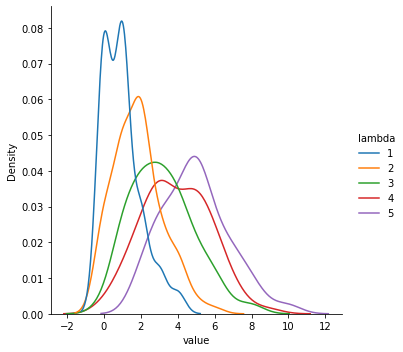

In [79]:
import pandas as pd
import seaborn as sns

df = pd.melt(
        pd.DataFrame({
            '1':list(app.Poisson(1.0).sample(100)),
            '2':list(app.Poisson(2.0).sample(100)),
            '3':list(app.Poisson(3.0).sample(100)),
            '4':list(app.Poisson(4.0).sample(100)),
            '5':list(app.Poisson(5.0).sample(100))
        }),
        var_name=["lambda"]
)

sns.displot(df, x="value", hue="lambda", kind="kde", height=5)

Now let's get into the Maximum Likelyhood Estimator to estimate the $\lambda$ for the distribution `p1`.

## 3. The Maximum Likelyhood Estimator <a class="anchor" id="third-bullet"></a>
---------- 

First what is the difference between a statistic and an estimator?  A statistic is any function of a sample.  An **estimator** is any function of a sample that is used to estimate a population parameter.  The **maximum likelyhood estimator** is the value of a population distribution $\lambda$ that maximizes the probability of observing the sample.  


We can find the MLE from a random sample $y_1, y_2, \, \ldots \,, y_{n}$ from $f(y_{i} \vert \, \lambda)$ then the **likelyhood function** is defined as,

$$ L(\lambda  \, \vert y_1, \, y_2, \, \ldots, \, y_n)  \; = \; \prod_{i=1}^{n}f(y_{i} \, \vert \, \lambda) $$


Then we can find the MLE $\widehat{\lambda}$ such that, 

$$ 
\frac{\partial L(\lambda \, \vert y_1, y_2, \ldots, y_n)}{\partial \lambda}  \; = \; 0 
$$

I should remark that an estimator is a **random variable** as a [random variable](https://en.wikipedia.org/wiki/Random_variable) is any function of the sample space that is measurable and has values in the $\mathbb{R}$.  The MLE has many important properties, the most important in my mind are some are,

1. It is a consistent estimator.
2. It is invariant, if $\widehat{\lambda}$ is the MLE of $\lambda$, then for any function $\tau(\lambda)$, the MLE of $\tau(\lambda)$ is $\tau(\widehat{\lambda})$.
3. The MLE is an asymptotically normal estimator.  That is $\widehat{\lambda} \; \sim \; N(\lambda, \, \mathcal{I}^{-1/2})$. 

To explain the first property we, must note that as an estimator is a function of the sample space it is also a random variable.  Let $X_1, \, \ldots, \, X_n$ be a sequence of random variables then $X_{i} \; \xrightarrow{\mathcal{P}} \; X$ if,

$$\forall \epsilon > 0, \; \lim\limits_{n \rightarrow \infty} P(\vert X_i - X \vert > \epsilon ) \; = \; 0$$ 

then we say the random variable converges in probability. For an estimator this property of convergence is called **consistency**. Consistency is a necessary condition of any estimator in statistics and basically signifies that  estimator eventually settles down to constant or some probability distribution of values. 

The second property of the MLE allows us to transform our likelyhood function into one that is easier to calculat the MLE with, i.e. the log-likelyhood function. That is the MLE, $\hat{\lambda}$ will satisfy, 

$$ \frac{\partial \log(L(\lambda \, \vert y_1, \, \ldots, y_n ))}{\partial \lambda}  \; = \; 0 $$


The third property of asymptotic normality of the MLE is helpful in modeling, since your standardized residuals are normal. Hence the sum of squares of the residuals are $\chi^2$ distributed.  This allows us to define confidence intervals around of estimates.



For the Poisson distribution, the likelyhood function is 

$$
\begin{align} L(\lambda  \, \vert y_1, \, y_2, \, \ldots, \, y_n)  
\; &= \; 
\prod_{i=1}^{n} \frac{e^{-\lambda} \, \lambda^{y_i}} {y_i!} \newline
&= \; 
e^{-n \, \lambda} \lambda^{n \, \bar{y}_{n}}  \frac{1} {\prod_{i=1}^{n} y_i!}
\end{align}
$$

We take the log of both sides and then setting the derivative equal to zero we find


$$
- n  \,  + \, \frac{n \, \bar{y}_{n}}{\widehat{\lambda}} \, = \, 0
$$

Then solving for $\hat{\lambda}$ we find the MLE is,


$$ \widehat{\lambda} \, = \, \bar{y}_{n} $$


In [82]:
def mle(sample):
    return sum(list(sample)) / len(list(sample))

lam = mle(sample)
print(f"lambda = {lam}") 

lambda = 3.013


Our estimate for $\lambda$ is pretty close! 

Now, since the maximum likelihood estimator is the mean we know it satifies the [Central Limit Theorem](https://en.wikipedia.org/wiki/Central_limit_theorem),


$$ \frac{\bar{y} \, - \, \mu_{y}}{\sigma_{y}\, / \, n} \; \xrightarrow{\mathcal{P}} \; N(0,1) $$

Hence we can repeatedly sample `p1` and compute the distribution of the MLE for various values of sample size $n$ to show how the MLE converges in distribution.

In [100]:
# sample the MLE 100 times for each n = 10, 50, 100, 500, 1000
samples = [ [ mle(p1.sample(n)) for k in range(100)] for n in [10, 50, 100, 500, 1000]]

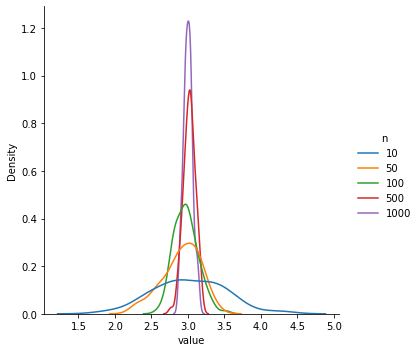

In [104]:
import numpy as np
sample_df = pd.melt(
                pd.DataFrame(np.array(samples).T, 
                             columns=['10','50','100','500','1000']),
                var_name=["n"]
)

# plot the MLE for various value of sample size
sns.displot(sample_df, x="value", hue="n", kind="kde", height=5,)

As $n \rightarrow \infty$ we see the MLE $\bar{y}$ has a distribution that is more sharply peaked around $3$ and hence shows that the esimator is converging to the true value!

We have seen that the MLE $\widehat{\lambda_{n}}$ converges to the true value of $\lambda$, but for any finite value of $n$ the esimator can be incorrect.  How to we measure our confidence in our estimator $\widehat{\lambda_{n}}$?  The answer is through confidence intervals and Fisher interval.

## 3. Confidence Intervals From The Fisher Information
-------------------
Given a distribution $y_{i} \, \sim \, f(y \, \vert \, \alpha)$ for $i \, = \, 1, \ldots , n$ and the likelyhood function,

$$ L(\alpha \, | \, \textbf{y}) \; = \; \prod_{i=1}^{n} \,  f(y_i \, \vert \, \alpha) $$

We define the [score statistic](https://en.wikipedia.org/wiki/Score_(statistics)) $S(\alpha)$ to be,

$$
S(\alpha) \; = \; \frac{d\log \left(L(\alpha \, | \, \textbf{y}) \right)}{d\alpha} 
$$

For a distribution from the [exponential family](https://en.wikipedia.org/wiki/Exponential_family) the score function satisfies,

$$
E_{y}[S] \; = \; 0
$$

Another important property of the score statistic is that it satisfies,

$$ S(\widehat{\alpha})  \; = \; 0$$

for the MLE $\widehat{\alpha}$.  This property can be used to compute the MLE using the so-called [scoring algorithm](https://en.wikipedia.org/wiki/Scoring_algorithm) which is equivalent to [Newton–Raphson method](https://en.wikipedia.org/wiki/Newton%27s_method). The later method is more frequently used in calculations as it general optimization method and has many efficient implmentations.

The [**Fisher information**](https://en.wikipedia.org/wiki/Fisher_information) is defined as,

\begin{align}
\mathbb{I} \; &= \; \text{Cov}[S] \\
& = \; \text{Var}[ S S^{T}] \\
& = \; E_y[ - S'] \\
 &= \; E_{y} \left[  - \frac{d^{2}\log \left(L(\alpha \, | \, \textbf{y}) \right)}{d\alpha^{2}}  \right] 
\end{align}

The standard error for the maximum likelihood estimate $(\widehat{\alpha})$ will then be,

$$ \text{S.E.}(\widehat{\alpha}) \; = \; \frac{1}{\sqrt{\mathcal{I}}}$$


The curvature of the log-likelyhood at the MLE dictated by the Fisher information matrix. If $L$ flat then the $\mathbb{I}$ is small, so the MLE is not stable or well defined.  High Fisher information tells us the MLE is well defined and stable.


Now using Taylor's theorem on the score statistic we have that

$$ S(\alpha)  \; = \; \underbrace{S(\widehat{\alpha})}_{0} \, - \, (\alpha \, - \, \widehat{\alpha}) \,\mathcal{I}(\widehat{\alpha})$$

Thus for a constant $\mathbb{I}$, the MLE statifies

$$E_{y}(\widehat{\alpha} \, - \, \alpha) \; =  \; \mathbb{I}^{-1}\, E_{y}[S] \; = \; 0$$


and the variance of the MLE is,

\begin{align}
\text{Var}(\widehat{\alpha}) \; &= \; E_{y }[(\widehat{\alpha} \,  -\, \alpha)(\widehat{\alpha} \, -\, \widehat{\alpha} )^{T} ] \\
\; &= \; 
 \mathbb{I}^{-1} \, E_{y}[S S^{T}] \,  \mathbb{I}^{-1} \\
&= \;  \mathbb{I}^{-1} 
\end{align}

Then for an estimator $\alpha$ we know 

$$\frac{(\alpha \, - \, E(\alpha))}{\sqrt{\text{Var}(\alpha)}} 
\; \sim \; 
N(0,1)
\qquad \text{and}  \qquad 
\frac{(\alpha \, - \, E(\alpha))^{2}}{\text{Var}(\alpha)} 
\; \sim \; 
\chi^{2}(1) $$

 
For the score statistic this then becomes,
$$\frac{S}{\sqrt{\mathbb{I}}}
\; \sim \; 
N(0,1)
\qquad \text{and}  \qquad 
\frac{U^{2}}{\mathbb{I}}
\; \sim \; 
\chi^{2}(1) $$


And for the MLE where the Fisher Information is approximately constant we have shown that is normal,

\begin{equation}
 \widehat{\alpha} \; \sim \; N(\alpha, \, \mathbb{I}^{-1})
\end{equation}

These facts can be used to calculate confidence intervals for the MLE.}



